<a href="https://colab.research.google.com/github/soham-chitnis10/SAiDL-assignment/blob/main/RL/Reinforcement_Learning_using_Policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from gym import Env
from gym.utils import seeding
from gym.spaces import Box
import numpy as np
import random
import time
import matplotlib.pyplot as plt


class QuadraticEnv(Env):
    def __init__(self):
        self.seed()
        self.a = random.uniform(0,10)
        self.b = random.uniform(0,10)
        self.c = random.uniform(-10,10)
        self.d = random.uniform(-10,10)
        self.e = random.uniform(-10,10)
        self.f = random.uniform(-10,10)
        self.x = random.uniform(-4,4)
        self.y = random.uniform(-4,4)
        self.state = np.array([self.x,self.y,self.a,self.b,self.c,self.d,self.e,self.f])
        self.action_space = Box(low=-1, high=1, shape=(2,))
        self.low_state = np.array([random.uniform(-4,4)-5,random.uniform(-4,4)-5,self.a,self.b,self.c,self.d,self.e,self.f],dtype=np.float32)
        self.high_state = np.array([random.uniform(-4,4)+5,random.uniform(-4,4)+5,self.a,self.b,self.c,self.d,self.e,self.f],dtype=np.float32)
        self.observation_space = Box(low=self.low_state, high=self.high_state)
        self.steps = 0
        self.set_minima()
    def set_minima(self):

        det = 4 * self.a * self.b - self.c * self.c
        while det == 0:
            self.reset()
            det = 4 * self.a * self.b - self.c * self.c
        
        self.x_min = (-2 * self.b * self.d + self.c * self.e)/det
        self.y_min = (self.c * self.d - 2 * self.a * self.e)/det   
    def seed(self,seed = None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    def step(self,action):
        done = False
        self.state[0]-= action[0][0]
        self.state[1]-= action[0][1]
        reward = self.reward()
        self.steps += 1
        if self.steps > 200:
          done = True
        elif abs(self.state[0]-self.x_min)<0.1 and abs(self.state[1]-self.y_min)<0.1:
          done = True
        return self.state,reward,done
    def render(self):
        pass
    def reset(self):
        self.a = random.uniform(0,10)
        self.b = random.uniform(0,10)
        self.c = random.uniform(-10,10)
        self.d = random.uniform(-10,10)
        self.e = random.uniform(-10,10)
        self.f = random.uniform(-10,10)
        self.set_minima()
        self.state = np.array([random.uniform(-4,4),random.uniform(-4,4),self.a,self.b,self.c,self.d,self.e,self.f])
        self.steps = 0
        return self.state
    def reward(self):
        state = self.state
        dist = np.sqrt((state[0]-self.x_min)**2 + (state[1]-self.y_min)**2)
        reward = 1/dist
        return reward
    def start_time(self):
        self.start = time.time()
    def end_time(self):
        self.end = time.time()


In [26]:
import torch
from torch.autograd import Variable
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

LOG_SIG_MAX = 2
LOG_SIG_MIN = -20



class Gaussian_Policy(nn.Module):
    '''
    Gaussian policy that consists of a neural network with 1 hidden layer that
    outputs mean and log std dev (the params) of a gaussian policy
    '''

    def __init__(self, num_inputs, hidden_size, action_space):

       	super(Gaussian_Policy, self).__init__()

        self.action_space = action_space
        num_outputs = action_space.shape[0] # the number of output actions
        self.linear = nn.Linear(num_inputs, hidden_size)
        self.mean = nn.Linear(hidden_size, num_outputs)
        self.log_std = nn.Linear(hidden_size, num_outputs)

    def forward(self, inputs):

        # forward pass of NN
        x = inputs
        x = F.relu(self.linear(x))

        mean = self.mean(x)
        log_std = self.log_std(x) # if more than one action this will give you the diagonal elements of a diagonal covariance matrix
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX) # We limit the variance by forcing within a range of -2,20 as policy gradient has tendency of high variance
        std = log_std.exp()

        return mean, std

In [27]:

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal



class REINFORCE:
    '''
    Implementation of the basic online reinforce algorithm for Gaussian policies.
    '''

    def __init__(self, num_inputs, hidden_size, action_space, lr_pi = 3e-4,gamma = 0.99):

        self.gamma = gamma
        self.action_space = action_space
        self.policy = Gaussian_Policy(num_inputs, hidden_size, action_space)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr = lr_pi)


    def select_action(self,state):

        state = torch.from_numpy(state).float().unsqueeze(0) # just to make it a Tensor obj
        # get mean and std
        mean, std = self.policy.forward(state)

        # create normal distribution
        normal = Normal(mean, std)

        # sample action
        action = normal.sample()

        # get log prob of that action
        ln_prob = normal.log_prob(action)
        ln_prob = ln_prob.sum()
	# squeeze action into [-1,1]
        action = torch.tanh(action)
        # turn actions into numpy array
        action = action.numpy()

        return action, ln_prob #, mean, std

    def train(self, trajectory):

        '''
        The training is done using the rewards-to-go formulation of the policy gradient update of Reinforce.
        trajectory: a list of the form [( state , action , lnP(a_t|s_t), reward ), ...  ]
        '''

        log_probs = [item[2] for item in trajectory]
        rewards = [item[3] for item in trajectory]
        states = [item[0] for item in trajectory]
        actions = [item[1] for item in trajectory]

	#calculate rewards to go
        R = 0
        returns = []
        for r in rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns).cuda()

        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            log_prob = log_prob.cuda()
            policy_loss.append( - log_prob * R)


        policy_loss = torch.stack( policy_loss ).sum()
        # update policy weights
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        torch.cuda.empty_cache()
        return policy_loss

number of actions:Box(-1.0, 1.0, (2,), float32), dim of states: 8
Episode: 0 Reward: 3.914926171674785 function: 7.077248984874824x^2 + 6.71261956133855y^2 + -2.399444223208775xy + -5.309891438454477x + -2.6550255881470726y + -2.543013206375761 x:-138.22716481552786 y:-201.6533146556397 x_min:0.4214308848000111 y_min:0.2730845578734949
Episode: 1 Reward: 3.491697109546978 function: 6.641827630242126x^2 + 1.277040714595311y^2 + 4.813110134508701xy + -3.001359553245848x + 9.36504225132255y + 5.58888044441413 x:-141.30688890540034 y:-195.68307598214136 x_min:4.900864845654039 y_min:-12.902268553841774
Episode: 2 Reward: 4.694075055208879 function: 4.5917130299073525x^2 + 0.30973437287701966y^2 + 9.942227483637858xy + 0.16763104809158058x + 7.612970151091062y + -2.0208340878095292 x:-124.5193961247688 y:-199.756238816056 x_min:-0.8113655671066389 y_min:0.7325807679313772
Episode: 3 Reward: 10.83690394657415 function: 5.867601930100133x^2 + 1.007263924156y^2 + -8.045489707061614xy + 2.35197

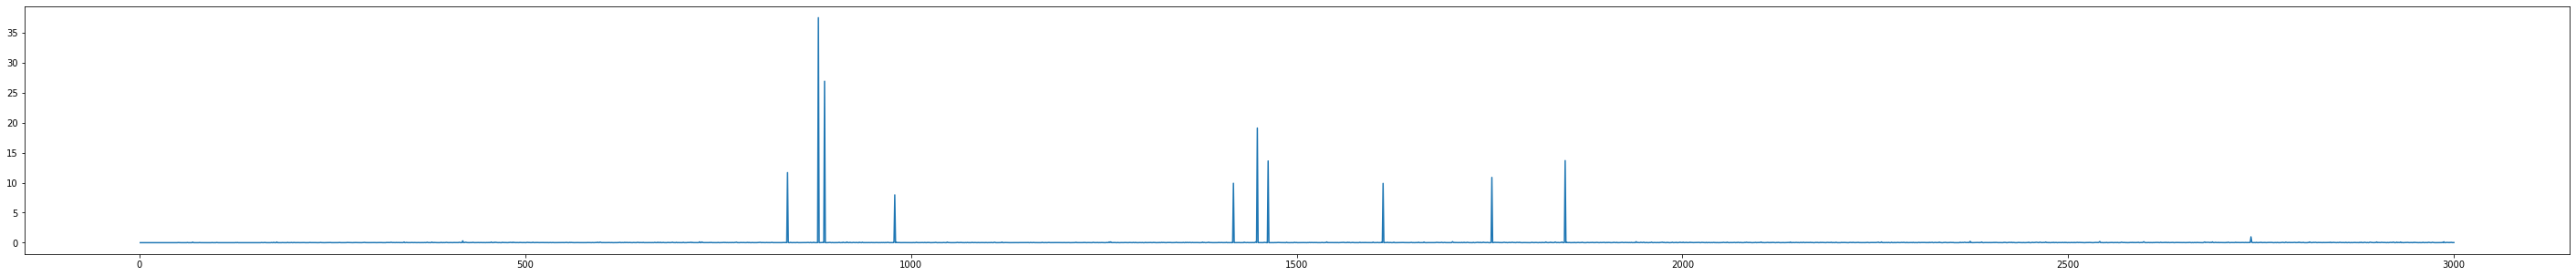

In [28]:
import torch
from torch.autograd import Variable
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gym


def main():

    # create env
    env = QuadraticEnv()
    env.seed(456)
    torch.manual_seed(456)
    np.random.seed(456)

    hidden_size = 32

    # get env info
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space

    print("number of actions:{0}, dim of states: {1}".format(action_dim,state_dim))

    # create policy
    policy = REINFORCE(state_dim, hidden_size, action_dim)

    

    # start of experiment: Keep looping until desired amount of episodes reached
    max_episodes = 3000
    total_episodes = 0 # keep track of amount of episodes that we have done
    max_reward = 0
    max_reward_ep = 0
    last_reward = []
    while total_episodes < max_episodes:

        obs = env.reset()
        done = False
        trajectory = [] # trajectory info for reinforce update
        episode_reward = 0 # keep track of rewards per episode
        while not done:
            action, ln_prob = policy.select_action(np.array(obs))
            next_state, reward, done = env.step(action)
            trajectory.append([obs, action, ln_prob, reward, next_state, done])
            obs = next_state
            episode_reward += reward
        last_reward.append(env.reward())
        print(f'Episode: {total_episodes} Reward: {episode_reward} function: {env.a}x^2 + {env.b}y^2 + {env.c}xy + {env.d}x + {env.e}y + {env.f} x:{env.state[0]} y:{env.state[1]} x_min:{env.x_min} y_min:{env.y_min}')
        if episode_reward > max_reward:
            max_reward = episode_reward
            max_reward_ep = total_episodes

        total_episodes += 1
        policy_loss = policy.train(trajectory)
    
    print(f'Max Reward is {max_reward} occured on episode {max_reward_ep}')
    eps = [ep for ep in range(1,max_episodes+1)]
    plt.figure(figsize=(50,5))
    plt.plot(eps,last_reward)
    plt.show()


if __name__ == '__main__':

    main()

The reward function only depends on the state which is the x and y coordinates. The maimum episode length is 200 and the agent ran for 3000 episodes. Maximum reward was 101 which occured on the episode 2102. The graph shows the last reward with episodes. The graph shows how much near is it to the minima. The peak is observed in between 500 and 1000 episodes. The maximum reward observed over 3000 episodes does not have a peak on the graph from which it can be infered that Maximum reward has less corelation with agent reaching the minima.